# 1. Data ingestion

 1.1 Connect colab
 import library 
 1.2 Connect Data time series of SOC 

 +) It is excel file; 
 
+) Visualize the data on python 



In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# GDRIVE = '/content/drive/My Drive'
# COLAB_FOLDER = 'Colab Notebooks'

Reimport dataframe on station

#1.1 Import library

+) fundametal packages: pandas for data; numpy for calucation; 


In [4]:
!pip install xlrd
# !pip install -q keras
# !conda install keras
import pandas as pd
import seaborn as sns; sns.set()

import numpy as np
from numpy import array
from numpy import hstack

import time
from dateutil.parser import parse
import pywt
from matplotlib import pyplot as plt
from scipy.stats import kurtosis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA,ARMAResults

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error


import statistics
from datetime import date
import calendar
import random
from statistics import mean

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers



Using TensorFlow backend.
/home/cuongbv/anaconda3/envs/ts/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cuongbv/anaconda3/envs/ts/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cuongbv/anaconda3/envs/ts/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cuongbv/anaconda3/envs/

#Link data

In [5]:
# path = "all_data_3m_19_9.xlsx"
# full_path = GDRIVE+'/'+COLAB_FOLDER+'/'+path
# path = full_path
path = './SOC/all_data_3m_19_9.xlsx'

In [6]:
a = pd.read_excel(path)
print(a.head())

        @timestamp per 10 minutes Sum of IN_BYTES Sum of IN_PKTS  \
0  January 9th 2019, 00:00:00.000         574,886          2,095   
1  January 9th 2019, 00:10:00.000       2,862,289          3,614   
2  January 9th 2019, 00:20:00.000       2,869,116          7,917   
3  January 9th 2019, 00:30:00.000       5,824,886         15,138   
4  January 9th 2019, 00:40:00.000         477,036          2,428   

  Sum of OUT_BYTES Sum of OUT_PKTS Count  
0          944,286           1,901   196  
1          802,737           2,481   187  
2        1,527,647           7,197   192  
3        3,179,064           3,110   180  
4          946,656           2,309   186  


#1.PREPROCESSING

In [7]:
#Lay data
def get_data(path, num):
    df = pd.read_excel(path)
    times = list(df["@timestamp per 10 minutes"])
    keys = list(df.keys())
    for key in keys[1:num]:

        count = [float(x.replace(",", "")) for x in list(df[key])] #transform string interger to interger

        start_time = parse(times[0]).date()
        end_time = parse(times[len(times) - 1]).date()
        range_date = pd.date_range(start=start_time, end=end_time)
        range_time = pd.date_range(start="00:00", end="23:50", freq="10T")
        range_time = [x.time() for x in range_time]
        table_time = {}

        for date in range_date:
            table_time[str(date.date())] = [0] * len(range_time)

        index = [str(x) for x in range_time]
        data = pd.DataFrame(data=table_time, index=index)
        for i in range(len(count)):
            get_time = parse(times[i])
            data[str(get_time.date())][str(get_time.time())] = int(count[i])

        for date in data.keys():
            if list(data[date]).count(0) >= 1: data = data.drop([date], axis=1)
    return data, index

x,y=get_data('./SOC/all_data_3m_19_9.xlsx',4)
print(x['2019-01-09'])
print(y)


#lay data theo thu
def get_prdata(data, index):
    data_wednesday = {}
    data_tuesday = {}
    data_monday = {}
    data_thurs = {}
    data_fri = {}

    data_sat = {}
    data_sun = {}
    for i in range(len(data.columns)):
        get_time = parse(data.columns[i])
        if get_time.weekday() == 2:
            data_wednesday[data.columns[i]] = data[data.columns[i]]
        if get_time.weekday() == 1:
            data_tuesday[data.columns[i]] = data[data.columns[i]]
        if get_time.weekday() == 0:
            data_monday[data.columns[i]] = data[data.columns[i]]
        if get_time.weekday() == 3:
            data_thurs[data.columns[i]] = data[data.columns[i]]
        if get_time.weekday() == 4:
            data_fri[data.columns[i]] = data[data.columns[i]]
        if get_time.weekday() == 5:
            data_sat[data.columns[i]] = data[data.columns[i]]
        if get_time.weekday() == 6:
            data_sun[data.columns[i]] = data[data.columns[i]]

    wed = pd.DataFrame(data_wednesday, index=index)

    tues = pd.DataFrame(data_tuesday, index=index)

    mon = pd.DataFrame(data_monday, index=index)

    thurs = pd.DataFrame(data_thurs, index=index)

    fri = pd.DataFrame(data_fri, index=index)

    sat = pd.DataFrame(data_sat, index=index)

    sun = pd.DataFrame(data_sun, index=index)

    # print(tues.iloc[5:,-3:-1])

    # Lấy dữ liệu ngày làm việc vào df
    cols = [i for i in data.columns[-9:-1] if i not in [sat.columns[-1], sun.columns[-1]]]
    df = data.loc[:, cols].T

    data = df.copy()
    return df, data

df, data = get_prdata(x, y)
print(df)
print("******************************")
print(data)

00:00:00        944286
00:10:00        802737
00:20:00       1527647
00:30:00       3179064
00:40:00        946656
               ...    
23:10:00    1661664760
23:20:00     945691394
23:30:00    1182302944
23:40:00    1420944880
23:50:00    1405525822
Name: 2019-01-09, Length: 144, dtype: int64
['00:00:00', '00:10:00', '00:20:00', '00:30:00', '00:40:00', '00:50:00', '01:00:00', '01:10:00', '01:20:00', '01:30:00', '01:40:00', '01:50:00', '02:00:00', '02:10:00', '02:20:00', '02:30:00', '02:40:00', '02:50:00', '03:00:00', '03:10:00', '03:20:00', '03:30:00', '03:40:00', '03:50:00', '04:00:00', '04:10:00', '04:20:00', '04:30:00', '04:40:00', '04:50:00', '05:00:00', '05:10:00', '05:20:00', '05:30:00', '05:40:00', '05:50:00', '06:00:00', '06:10:00', '06:20:00', '06:30:00', '06:40:00', '06:50:00', '07:00:00', '07:10:00', '07:20:00', '07:30:00', '07:40:00', '07:50:00', '08:00:00', '08:10:00', '08:20:00', '08:30:00', '08:40:00', '08:50:00', '09:00:00', '09:10:00', '09:20:00', '09:30:00', '09:40

#2.SAX + ARIMA + LSTM module

#2.1.Tách trend và residual từ chuỗi original

In [12]:
#Tính giá trị trung bình cho các mốc quantile
def tinh_score(df, value):
    q = df.quantile([.2, .4, .6, .8], axis = 'columns')
    level_1 = q.iloc[0,:].mean()
    level_2 = q.iloc[1,:].mean()
    level_3 = q.iloc[2,:].mean()
    level_4 = q.iloc[3,:].mean()

    score = ''
    if (value<=level_1):
        score = 'A'
    elif (value>level_1) & (value<=level_2):
        score = 'B'
    elif (value>level_2) & (value<=level_3):
        score = 'C'
    elif (value>level_3) & (value<=level_4):
        score = 'D'
    elif (value>level_4):
        score = 'E'
    return (score)
#Phân chia các điểm dữ liệu vào các mốc quantile tương ứng
def trich_dl(df):
    A = []
    B = []
    C = []
    D = []
    E = []
    GTTB = []
    temp_table = pd.DataFrame([])

    for column in range (df.shape[1]):
        list_score=[]
        for row in range(len(df)):
            value = df.iloc[row, column]
            q = df.quantile([.2, .4, .6, .8], axis = 'columns')
            level_1 = q.iloc[0,:].mean()
            level_2 = q.iloc[1,:].mean()
            level_3 = q.iloc[2,:].mean()
            level_4 = q.iloc[3,:].mean()

            score = ''
            if (value<=level_1):
                score = 'A'
                A.append(value)
            elif (value>level_1) & (value<=level_2):
                score = 'B'
                B.append(value)
            elif (value>level_2) & (value<=level_3):
                score = 'C'
                C.append(value)
            elif (value>level_3) & (value<=level_4):
                score = 'D'
                D.append(value)
            elif (value>level_4):
                score = 'E'
                E.append(value)
            list_score.append(score)

        temp_table[column+1]=list_score
    GTTB = [A, B, C, D, E]
    temp_table.index = df.index
    
    print("*************************************************")
    print("temp_table:")
    print(temp_table)
    print("df.index")
    print(df)
    print("*************************************************")
    return (temp_table, GTTB)
#Đánh giá độ chính xác mô hình ARIMA dự báo thành phần xu hướng
def evaluate_models(trent, p_values,  q_values):
  #trent = trent.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in range(2,p_values):
    for q in range(2,q_values):
      for d in range(0,3):
        order = (p,d,q)
        try:
          model = ARIMA(trent,order)
          model_fit = model.fit()
          score = model_fit.aic
          if score < best_score:
              best_score,best_cfg = score, order
          print('ARIMA%s AIC=%.3f' % (order,score))
        except:
          continue
  print('Best ARIMA%s Score=%.3f' % (best_cfg, best_score))
  return  best_cfg

# Fit model Arima với best_cfg
def fit_model(_data,_p,_d,_q):
  try:
    model = ARIMA(_data,(_p,_d,_q))
    model_fit = model.fit()
  except:
    return fit_model(_data,_p,_d,_q-1)
  else:
    return model_fit

### LSTM
#Xử lý phần dư thừa
def get_len_fit_wavelet(len_residual):
  if len_residual % 4 == 0:
    return len_residual
  else:
    return get_len_fit_wavelet(len_residual-1)

# ap dung bien doi wavelet cho residual data
def wavelet_transform(_residual_data):
  (ca, cd) = pywt.dwt(_residual_data,'haar')# Lọc lần 1
  (ca1,cd1)= pywt.dwt(cd,'haar')# Lọc lần 2 ; cần tìm hiểu haar
  residual_data_rec1 = pywt.idwt(ca1, None, 'haar')# bỏ đi chuỗi cao lần 2 để lấy lại chuỗi residual_data_rec1
  residual_data_rec = pywt.idwt(ca,residual_data_rec1 , 'haar')# gộp phần chuỗi thấp và residual_data_rec1
  return residual_data_rec

#Lọc Null cho chuỗi
def timeseries_to_supervised(data, lag=1):
  df = pd.DataFrame(data)
  columns = [df.shift(i) for i in range(1, lag+1)]
  columns.append(df)
  df = pd.concat(columns, axis=1)
  #df.fillna(0, inplace=True)
  df.dropna(inplace=True)
  return df

# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    print(train_scaled)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [float(x) for x in X.reshape(X.shape[1],1)] + [float(value.reshape(-1))]
    array = np.array(new_row)
    inverted = scaler.inverse_transform(array.reshape(1, array.shape[0]))
    return inverted[0, -1]

#Phân chia chuỗi
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

#Định nghĩa chuỗi đầu vào sau khi loại bỏ nhiễu
def define_input(reswavelet_scaled):
    seq = []
    for i in range(reswavelet_scaled.shape[1]):
        temp = array(reswavelet_scaled[:,i])
        temp = temp.reshape((len(temp), 1))
        seq.append(temp)
    dataset = hstack(([i for i in seq]))
    n_steps = 1
    X, y = split_sequences(dataset, n_steps)
    return X, y

# fit an LSTM network to training data
def fit_lstm(X, y, batch_size, nb_epoch, neurons):
  n_features = X.shape[2]
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(1, n_features)))
  model.add(Dense(1))
  adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #sgd = optimizers.SGD(lr=0.003, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='mean_squared_error', optimizer=adam)
  for i in range(nb_epoch):
      model.fit(X, y, epochs=1, batch_size=batch_size,verbose=0, shuffle=False)
      model.reset_states()
  n_batch_predict = 1
  new_model = Sequential()
  new_model.add(LSTM(neurons, batch_input_shape=(n_batch_predict, X.shape[1], X.shape[2]), stateful=True))
  new_model.add(Dense(1))
  old_weights = model.get_weights()
  new_model.set_weights(old_weights)
  adam= optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
  new_model.compile(loss = 'mean_squared_error', optimizer = adam)
  return new_model

#Lay phan xu huong tu du lieu goc
def SAX_get_trend(df):
    b = trich_dl(df)
    data_symbol_full = b[0]
    GTTB = b[1]

    A = mean(GTTB[0])
    B = mean(GTTB[1])
    C = mean(GTTB[2])
    D = mean(GTTB[3])
    E = mean(GTTB[4])

    list_GTTB = []
    for column in range(df.shape[1]):
        sum = 0.0
        for row in range(len(data_symbol_full)):
            value = data_symbol_full.iloc[row, column]
            if (value == 'A'):
                sum = sum + A
            elif (value == 'B'):
                sum = sum + B
            elif (value == 'C'):
                sum = sum + C
            elif (value == 'D'):
                sum = sum + D
            elif (value == 'E'):
                sum = sum + E
        list_GTTB.append(sum / len(data_symbol_full))

    #for i in range(len(list_GTTB)):
        #print(i + 1, list_GTTB[i])

    #for i in range(len(list_GTTB)):
        #print(tinh_score(df, list_GTTB[i]), end=' ')
    # Lấy dữ liệu 2 tuần cuối: 1 tuần train - 1 ngày test
    # Lấy trend
    trent = []
    for j in range(df.shape[0] - 2, df.shape[0]):
        for i in range(len(data_symbol_full.iloc[j, :])):
            value = data_symbol_full.iloc[j, i]
            if (value == 'A'):
                trent.append(A)
            elif (value == 'B'):
                trent.append(B)
            elif (value == 'C'):
                trent.append(C)
            elif (value == 'D'):
                trent.append(D)
            elif (value == 'E'):
                trent.append(E)
    return trent
# Chuỗi gốc
def get_original(df, data):
    original = []
    for j in range(df.shape[0] - 2, df.shape[0]):
        for i in range(len(data.iloc[j, :])):
            original.append(data.iloc[j, i])
    return original

# Phần dư thừa
def get_resisual(trent,original):
    residual = []
    for i in range(len(trent)):
        residual.append(abs(trent[i] - original[i]))

    # Biểu diễn tách chuỗi gốc = trend + dư thừa
    plt.figure(figsize=(20, 6))
    plt.plot(trent, label='trend-data')
    plt.plot(original, label='original')
    plt.plot(residual, label='residual')

    plt.legend()
    plt.show()
    return residual

#2.2.Dự đoán chuỗi trend, chuỗi residual và chuỗi gốc

In [13]:
#Dự đoán một bước cho phần trend
def forecast_one_step_for_trend(_history,_test, order):
  history =[x for x in _history]
  predictions = list()
  #order =(8,1,7)
  #order = evaluate_models(history,10,10)
  #print(order)
  for i in range(len(_test)):
    model_fit = fit_model(history,order[0],order[1],order[2])
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(_test[i])
  return predictions

# Dự đoán trend
def pred_trend(trent):
    one_step_for_trend = forecast_one_step_for_trend(trent[0:-144], trent[-144:], evaluate_models(trent, 3, 5))

    # Vẽ trend dự báo - trend test
    plt.figure(figsize=(20, 6))
    plt.plot(one_step_for_trend, label='trend - predict')
    plt.plot(trent[-144:], label='trend')
    plt.legend()
    plt.show()
    # plt.savefig('trend')
    return one_step_for_trend

# Phần dư thừa qua wavelet loại bỏ nhiễu
def pre_trainLSTM(residual):
    residual_wavelet = wavelet_transform(residual[len(residual) - get_len_fit_wavelet(len(residual)):])
    diff_rw = difference(residual_wavelet, 1)
    supervised = timeseries_to_supervised(diff_rw, 4)
    supervised_values = supervised.values

    # Thêm chuỗi phụ vào chuỗi dư thừa
    # supervised_values = np.vstack((supervised_values.T[:-1,:], tues.iloc[:,-3:].T.values.reshape(-1)[5:]))
    # print('super value: ', supervised_values)
    # print('tue: ', tues.iloc[:,-3:].T.values.reshape(-1)[5:])
    # supervised_values = np.vstack((supervised_values, wed.iloc[:,-3:].T.values.reshape(-1)[5:]))
    # supervised_values = np.vstack((supervised_values, supervised_values[-1,:])).T
    # print(supervised_values.shape)

    # Scale, chia train-test cho phần dư thừa+chuỗi phụ
    train_residual_wavelet, test_residual_wavelet = supervised_values[0:-144], supervised_values[-144:]
    scaler, train_reswavelet_scaled, test_reswavelet_scaled = scale(train_residual_wavelet, test_residual_wavelet)

    X, y = define_input(train_reswavelet_scaled)

    # Fit model LSTM với chuỗi
    lstm_model = fit_lstm(X, y, 1, 100, 7)
    return test_reswavelet_scaled, lstm_model, scaler, residual_wavelet

# Dự đoán 1 bước giá trị residual bởi LSTM
def forecast_one_step_for_lstm(model, X_, _scaler, _orgin_bfdiff):
  predictions = list()
  for i in range(len(X_)):
    X = X_[i]
    yhat = model.predict(X.reshape(1,1,X.shape[1]))
    # invert scaling
    yhat = invert_scale(_scaler, X, yhat)
    # invert diffence
    yhat = inverse_difference(_orgin_bfdiff, yhat, len(X_)+1-i)
    # append predict
    predictions.append(yhat)
  return predictions
  
#  Dự đoán Test phần residual
def pred_testLSTM(test_reswavelet_scaled, lstm_model, scaler, residual_wavelet, residual):
    X_, y_ = define_input(test_reswavelet_scaled)
    # print('X: ', X)
    # print('y: ', y)
    one_step_for_residual = forecast_one_step_for_lstm(lstm_model, X_, scaler, residual_wavelet)

    # Vẽ dự đoán chuỗi và test
    plt.figure(figsize=(20, 6))
    plt.plot(one_step_for_residual, label='predict')
    plt.plot(residual[-144:], label='residual-original')
    plt.legend()
    plt.show()
    # plt.savefig('predict')
    return one_step_for_residual

# Dự báo cho chuỗi gốc
def pred_test_original(one_step_for_trend, one_step_for_residual, original): 
    one_step_forecast_result = np.asarray([float(i) for i in one_step_for_trend]) + np.asarray(one_step_for_residual)

    # Vẽ dự báo - chuỗi gốc test
    plt.figure(figsize=(20, 6))
    plt.plot(one_step_forecast_result, label='predict-result')
    plt.plot(original[-144:], label='original')
    plt.legend()
    plt.show()
    # plt.savefig('original.png')
    return one_step_forecast_result

#3.Đánh giá mô hình

In [14]:
# Đánh giá model
def Mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def Mean_absolute_error(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)
    
def Root_mean_squared_error(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

def evaluate_model(original, one_step_forecast_result):
    mape = Mean_absolute_percentage_error(original[-144:], one_step_forecast_result)
    mae = Mean_absolute_error(original[-144:], one_step_forecast_result)
    rmse = Root_mean_squared_error(original[-144:], one_step_forecast_result)

    print('Timeseries forecast: ',one_step_forecast_result)
    print('Mean absolute percentage error: ', mape)
    print('Mean absolute error: ', mae)
    print('Root mean squared error: ', rmse)
    return mape, mae, rmse

def case():
    count = 0
    possible_case=['inbyte','outbyte','inpkts','outpkts','count']
    num1 = possible_case.index('inbyte') + 2
    num2 = possible_case.index('outbyte') + 2 
    num3 = possible_case.index('inpkts') + 2
    num4 = possible_case.index('outpkts') + 2
    num5 = possible_case.index('count') + 2
    while 1:
     if count == 10: break
     num = input("Nhap truong can du doan: ")
     if num == possible_case[0]:
      num = num1
      break
     if num == possible_case[1]:
      num = num2
      break
     if num == possible_case[2]:
      num = num3
      break
     if num == possible_case[3]:
      num = num4
      break
     if num == possible_case[4]:
      num = num5
      break
     else: print("Truong nhap khong hop le")
     count+=1
    return num


#4.Main

Nhap truong can du doan: inbyte
*************************************************
temp_table:
           1   2   3   4   5   6   7   8   9   10   ... 135 136 137 138 139  \
2019-03-30   D   B   A   C   B   B   A   B   A   B  ...   E   E   E   E   C   
2019-03-31   B   C   C   C   D   C   E   D   D   D  ...   E   E   E   D   C   
2019-04-01   C   B   C   C   C   D   D   D   C   D  ...   E   E   E   E   D   
2019-04-02   D   D   D   D   D   D   D   D   D   D  ...   E   E   E   D   B   
2019-04-03   C   B   C   C   C   C   B   C   D   C  ...   E   E   E   D   B   
2019-04-04   E   E   E   E   E   E   E   E   E   E  ...   E   D   C   D   B   
2019-04-05   B   C   C   C   C   C   E   E   C   B  ...   E   E   E   E   D   

           140 141 142 143 144  
2019-03-30   C   C   C   C   B  
2019-03-31   C   C   B   D   C  
2019-04-01   C   D   D   E   D  
2019-04-02   D   C   D   D   D  
2019-04-03   B   E   E   E   E  
2019-04-04   C   C   C   B   B  
2019-04-05   E   E   C   D   D  

[7 rows 

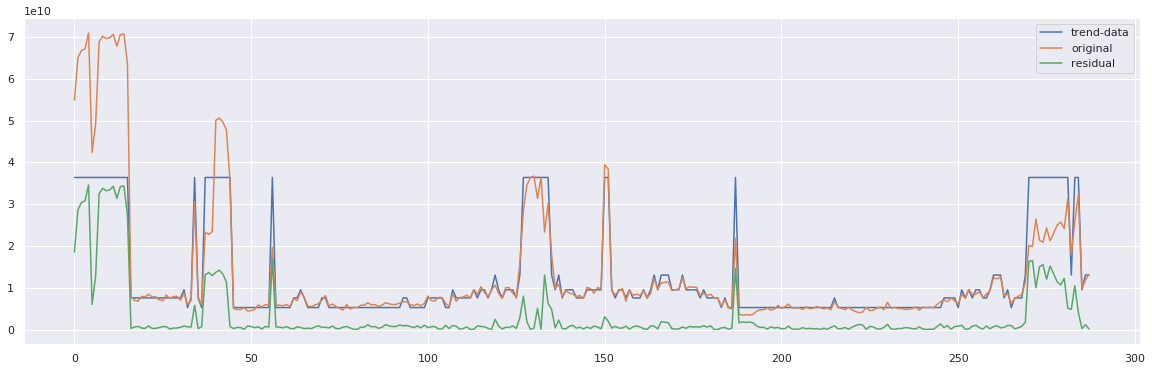

ARIMA(2, 0, 2) AIC=13836.254
ARIMA(2, 1, 2) AIC=13795.434
ARIMA(2, 2, 2) AIC=13754.911
ARIMA(2, 0, 3) AIC=13831.356
ARIMA(2, 1, 3) AIC=13797.235
ARIMA(2, 2, 3) AIC=13756.897
ARIMA(2, 0, 4) AIC=13834.432
ARIMA(2, 1, 4) AIC=13788.321
ARIMA(2, 2, 4) AIC=13758.591
Best ARIMA(2, 2, 2) Score=13754.911


/home/cuongbv/anaconda3/envs/ts/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/cuongbv/anaconda3/envs/ts/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/cuongbv/anaconda3/envs/ts/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/cuongbv/anaconda3/envs/ts/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/cuongbv/anaconda3/envs/ts/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse

/home/cuongbv/anaconda3/envs/ts/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/cuongbv/anaconda3/envs/ts/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


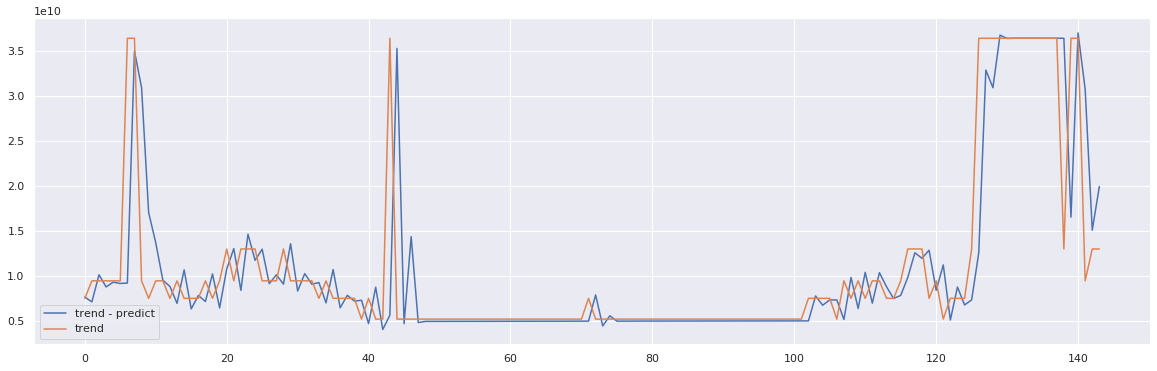

[[-1.21783874e-01  6.33646386e-01  4.65975756e-01  6.33646386e-01
   1.76153767e-01]
 [ 1.76153767e-01 -1.21783874e-01  6.33646386e-01  4.65975756e-01
   7.04322897e-01]
 [ 7.04322897e-01  1.76153767e-01 -1.21783874e-01  6.33646386e-01
   1.76153767e-01]
 [ 1.76153767e-01  7.04322897e-01  1.76153767e-01 -1.21783874e-01
   1.00000000e+00]
 [ 1.00000000e+00  1.76153767e-01  7.04322897e-01  1.76153767e-01
   3.91022952e-01]
 [ 3.91022952e-01  1.00000000e+00  1.76153767e-01  7.04322897e-01
   3.94892862e-01]
 [ 3.94892862e-01  3.91022952e-01  1.00000000e+00  1.76153767e-01
   3.91022952e-01]
 [ 3.91022952e-01  3.94892862e-01  3.91022952e-01  1.00000000e+00
   3.81764115e-01]
 [ 3.81764115e-01  3.91022952e-01  3.94892862e-01  3.91022952e-01
   2.85234393e-01]
 [ 2.85234393e-01  3.81764115e-01  3.91022952e-01  3.94892862e-01
   3.91215330e-01]
 [ 3.91215330e-01  2.85234393e-01  3.81764115e-01  3.91022952e-01
   2.85234393e-01]
 [ 2.85234393e-01  3.91215330e-01  2.85234393e-01  3.81764115e-01

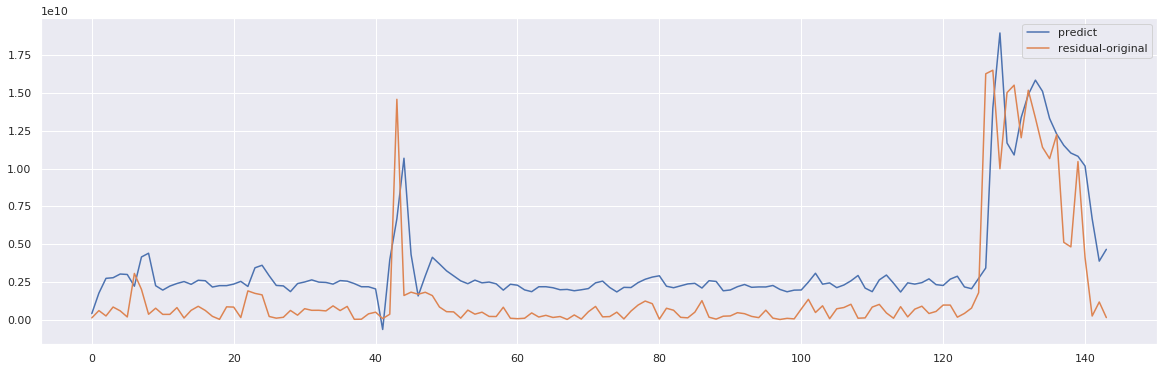

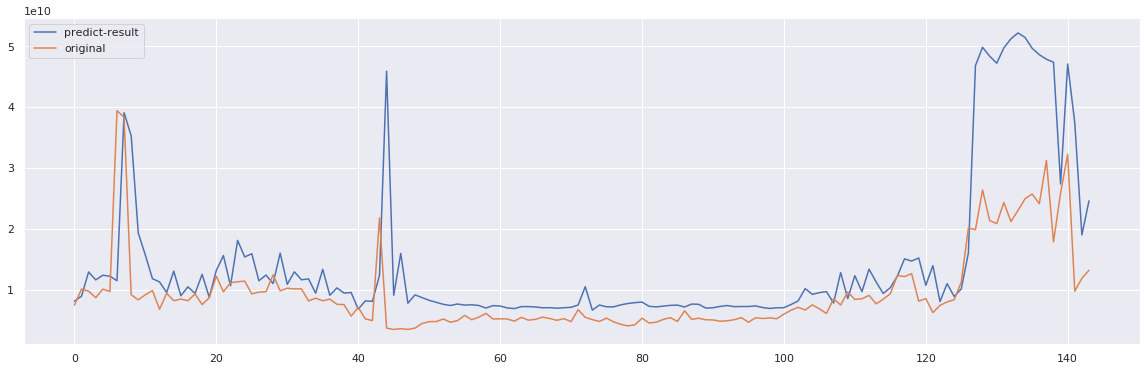

Timeseries forecast:  [8.09462512e+09 8.92040874e+09 1.29017207e+10 1.15949042e+10
 1.23642952e+10 1.21975724e+10 1.14608033e+10 3.91012837e+10
 3.53092714e+10 1.93093664e+10 1.56654336e+10 1.17904713e+10
 1.12638651e+10 9.52062481e+09 1.30464755e+10 8.98775045e+09
 1.04524260e+10 9.36630203e+09 1.25097780e+10 8.74509602e+09
 1.31604983e+10 1.56015008e+10 1.06340094e+10 1.80963177e+10
 1.53719423e+10 1.59043167e+10 1.14529518e+10 1.23954411e+10
 1.09907601e+10 1.59988185e+10 1.08673215e+10 1.29232584e+10
 1.16130010e+10 1.17616645e+10 9.40502077e+09 1.33272384e+10
 9.05832821e+09 1.02795103e+10 9.42738050e+09 9.51896818e+09
 6.78674558e+09 8.13583577e+09 8.07422320e+09 1.23603405e+10
 4.59307819e+10 9.05714490e+09 1.59603356e+10 7.76069648e+09
 9.13282819e+09 8.69121257e+09 8.23545971e+09 7.90429199e+09
 7.57459026e+09 7.38714125e+09 7.62564066e+09 7.44674032e+09
 7.50132858e+09 7.38326565e+09 6.96938167e+09 7.35898306e+09
 7.29643514e+09 6.98861950e+09 6.87150185e+09 7.19763664e+09
 7

In [15]:
### Main
def main():
    t0 = time.clock()
    num = case()
    data, index = get_data(path,num)
    df, data = get_prdata(data, index)
    trent = SAX_get_trend(df)
    original = get_original(df,data)
    residual = get_resisual(trent,original)
    one_step_for_trend = pred_trend(trent)
    test_reswavelet_scaled, lstm_model, scaler, residual_wavelet = pre_trainLSTM(residual)
    one_step_for_residual = pred_testLSTM(test_reswavelet_scaled, lstm_model, scaler, residual_wavelet, residual)
    one_step_forecast_result = pred_test_original(one_step_for_trend, one_step_for_residual, original)
    evaluate_model(original, one_step_forecast_result)
    print("Forecast time: ",time.clock()-t0)

if __name__=='__main__':
    main()


